We use the data used in the analysis reported on in (Jego et al, 2022)

In [1]:
import APEX as ap
import pyccl as ccl
import numpy as np
import sacc as sc
import time
import matplotlib.pyplot as plt

cosmo = ccl.Cosmology(
    Omega_c=0.261,
    Omega_b=0.049,
    h=0.677,
    n_s=0.9665,
    sigma8=0.8102,
    #transfer_function="bbks",
    #matter_power_spectrum="halofit")
)

import warnings

# The warning message to ignore
warning_message = "The FITS format without the 'sacc_ordering' column is deprecated."

# Apply the filter to ignore this specific UserWarning
warnings.filterwarnings("ignore", message=warning_message, category=UserWarning)

# ... the rest of your code that uses the sacc library

One should check the layout of the sacc file first:

In [2]:
sacc_data = sc.Sacc.load_fits('cls_cov_minimal_newcov.fits')

#print all tracers
print("Tracer combinations:", sacc_data.get_tracer_combinations())

Tracer combinations: [(np.str_('CIBLenz__0'), np.str_('eBOSSQSO__0')), (np.str_('CIBLenz__0'), np.str_('eBOSSQSO__1')), (np.str_('CIBLenz__1'), np.str_('eBOSSQSO__0')), (np.str_('CIBLenz__1'), np.str_('eBOSSQSO__1')), (np.str_('CIBLenz__2'), np.str_('eBOSSQSO__0')), (np.str_('CIBLenz__2'), np.str_('eBOSSQSO__1')), (np.str_('DELS__0'), np.str_('CIBLenz__0')), (np.str_('DELS__0'), np.str_('CIBLenz__1')), (np.str_('DELS__0'), np.str_('CIBLenz__2')), (np.str_('DELS__0'), np.str_('DELS__0')), (np.str_('DELS__1'), np.str_('CIBLenz__0')), (np.str_('DELS__1'), np.str_('CIBLenz__1')), (np.str_('DELS__1'), np.str_('CIBLenz__2')), (np.str_('DELS__1'), np.str_('DELS__1')), (np.str_('DELS__2'), np.str_('CIBLenz__0')), (np.str_('DELS__2'), np.str_('CIBLenz__1')), (np.str_('DELS__2'), np.str_('CIBLenz__2')), (np.str_('DELS__2'), np.str_('DELS__2')), (np.str_('DELS__3'), np.str_('CIBLenz__0')), (np.str_('DELS__3'), np.str_('CIBLenz__1')), (np.str_('DELS__3'), np.str_('CIBLenz__2')), (np.str_('DELS__3'

We will be using the CIB as the cosmological field here. This is the only option APEX currently has provisions for, though this is easily expanded and will be in good time. 

We require a .fits file that includes the angular power spectra pre-calculated from galaxy density maps, as well as a CIB flux file to build tracers in the custom (rather than simply using pyccl) that APEX does.

In [3]:
gd_file = 'cls_cov_minimal_newcov.fits'

cib_snu_file = 'filtered_snu_planck.fits'

We now define the workspaces we will be working with, as well as the tracer combinations to use in the model. (Remember to check this is the correct order in the angular power spectrum sacc file).

Check the documentation (if written) for how to reverse how APEX deals with the tracer types and how to set up aliases if the CIB file naming convention is different to that of the main sacc file.

In [4]:
gdwsp = ap.GalaxyDensityTracerWorkspace(
    sacc_file=gd_file,
    tracer_name_root="DELS__",
    max_index=3,
    cosmology=cosmo
)

cibwsp = ap.CIBIntensityTracerWorkspace(
    flux_fits_file=cib_snu_file,
    cosmology=cosmo,
    tracer_name_root="CIBLenz__",
    single_index=2
)

tracer_combos = [('DELS__0', 'DELS__0'),
                 ('DELS__1', 'DELS__1'),
                 ('DELS__2', 'DELS__2'),
                 ('DELS__3', 'DELS__3'),
                 ('DELS__0', 'CIBLenz__2'),
                 ('DELS__1', 'CIBLenz__2'),
                 ('DELS__2', 'CIBLenz__2'),
                 ('DELS__3', 'CIBLenz__2'),
                ]

s = ap.SaccWorkspace(gd_file, tracer_combinations=tracer_combos)


We will use the model by Sara Maleubre here, setting a max scale but not accounting for the effect of the beam window since the data already does this.

In [5]:
mmodel = ap.MaleubreModel(
    Tracer1Workspace=gdwsp,
    Tracer2Workspace=cibwsp,
    tracer_combos=tracer_combos,
    sacc_workspace=s,
    cosmology=cosmo,
    logged_N=True,
    k_max = 0.3,
    beam_window=False
)

To speed up the minimize run (this of course also works for the full MCMC run) we will precalculate the important quantities that will be repeatedly used by the model. 

One does not *have* to do this, but it is recommended.

In [6]:
mmodel.complete_precalculation()

The following code is simply here to show how different ways of setting up the model can effect the time it takes to run.

In [7]:
elapsed_times = []

for i in range(0,50):

    start_time = time.perf_counter()
    mmodel.lightweight_log_likelihood_function(b_gs=np.array([0.962442, 1.128193, 1.306405, 1.655859]),
        N_ggs=np.array([-7.11044, -9.346793, -9.893426, -8.653993]),
        A_ggs=np.array([4.841672, 8.002266, 11.706755, 27.02337]),
        N_gnus=np.array([-12.057331, -12.250513, -12.754224, -11.944748]),
        A_gnus=np.array([0.543653, 0.905731, 1.101477, 0.665272]),
        bpsfrs=np.array([0.018771, 0.051464, 0.089074, 0.135279]),)
    end_time = time.perf_counter()

    elapsed_time = end_time - start_time
    elapsed_times.append(elapsed_time)

np.mean(elapsed_times)

np.float64(0.0006146562599315075)

The following code is, I hope, an understandable way to set up the MCMC sampler. This is the standard method that APEX uses, but one can pass in a full Cobaya info dictionary if one prefers.

This runs a minimize on the model, to find the best fit. These parameter values are then taken and put into the graphing utility.

In [8]:
mcmc = ap.MCMCWorkspace(
    model=mmodel,
    likelihood_function='lightweight_log_likelihood_function',
    sacc_file=gd_file

)

params = ['b_g0', 'b_g1', 'b_g2', 'b_g3',
          'N_gg0', 'N_gg1', 'N_gg2', 'N_gg3',
          'A_gg0', 'A_gg1', 'A_gg2', 'A_gg3',
          'N_gnu0', 'N_gnu1', 'N_gnu2', 'N_gnu3',
          'A_gnu0', 'A_gnu1', 'A_gnu2', 'A_gnu3',
          'bpsfr0', 'bpsfr1', 'bpsfr2', 'bpsfr3']
mcmc.set_param_priors(
    params=params,
    priors=[
        (0, 4), (0, 4), (0, 4), (0, 4),
        (-12, -4), (-12, -4), (-12, -4), (-12, -4),
        (-100, 100), (-100, 100), (-100, 100), (-100, 100),
        (-15, -8), (-15, -8), (-15, -8), (-15, -8),
        (-100, 100), (-100, 100), (-100, 100), (-100, 100),
        (0, 1), (0, 1), (0, 1), (0, 1),
    ]
)

mcmc.set_param_references(
    params=params,
    references=[
        0.8, 0.9, 1.2, 1.5,
        -8, -8, -8, -8,
        7, 7, 7, 7,
        -12, -12, -12, -12,
        7, 7, 7, 7,
        0.059, 0.11, 0.15, 0.18,
    ]
)

mcmc.set_param_proposals(
    params=params,
    proposals=[
        0.1, 0.1, 0.1, 0.1,
        0.1, 0.1, 0.1, 0.1,
        1, 1, 1, 1,
        0.1, 0.1, 0.1, 0.1,
        1, 1, 1, 1,
        0.003, 0.003, 0.003, 0.003,
    ]
)

mcmc.set_grouped_params({
    'b_gs': ['b_g0', 'b_g1', 'b_g2', 'b_g3'],
    'N_ggs': ['N_gg0', 'N_gg1', 'N_gg2', 'N_gg3'],
    'A_ggs': ['A_gg0', 'A_gg1', 'A_gg2', 'A_gg3'],
    'N_gnus': ['N_gnu0', 'N_gnu1', 'N_gnu2', 'N_gnu3'],
    'A_gnus': ['A_gnu0', 'A_gnu1', 'A_gnu2', 'A_gnu3'],    
    'bpsfrs': ['bpsfr0', 'bpsfr1', 'bpsfr2', 'bpsfr3']
})

mcmc.MCMC_config(params, sampler_info={'minimize': {'seed':42}})

sampler = mcmc.minimize_run()


[<bound method maleubremodel.lightweight_log_likelihood_function of <apex.maleubremodel object at 0x7fc7d9ef9160>>] Initialized external likelihood.
[minimize] *WARNING* This run has been SEEDED with seed 42
[minimize] Initializing
[minimize] Run 1/2 will start from random initial point:
[minimize] {'b_g0': np.float64(0.8), 'b_g1': np.float64(0.9), 'b_g2': np.float64(1.2), 'b_g3': np.float64(1.5), 'N_gg0': np.float64(-8.0), 'N_gg1': np.float64(-8.0), 'N_gg2': np.float64(-8.0), 'N_gg3': np.float64(-8.0), 'A_gg0': np.float64(7.0), 'A_gg1': np.float64(7.0), 'A_gg2': np.float64(7.0), 'A_gg3': np.float64(7.0), 'N_gnu0': np.float64(-12.0), 'N_gnu1': np.float64(-12.0), 'N_gnu2': np.float64(-12.0), 'N_gnu3': np.float64(-12.0), 'A_gnu0': np.float64(7.0), 'A_gnu1': np.float64(7.0), 'A_gnu2': np.float64(7.0), 'A_gnu3': np.float64(7.0), 'bpsfr0': np.float64(0.059), 'bpsfr1': np.float64(0.11), 'bpsfr2': np.float64(0.15), 'bpsfr3': np.float64(0.18)}
[minimize] Run 2/2 will start from random initial 

[264, 462, 601, 736, 264, 462, 601, 736]
[  14.5   44.5   74.5  104.5  134.5  164.5  194.5  224.5  255.5  290.
  329.5  374.   424.5  482.   547.   621.   705.   800.5  909.  1032.
 1172.  1331.  1511.5 1716.5 1949.  2213.  2513.  2853.5 3240.  3679.5
 4178.5 4745.  5388.5 5937. ]
5936.999999999957 264
5936.999999999957 462
5936.999999999957 601
5936.999999999957 736
3
5936.999999999957 264
[2.65496221e-06 5.41330659e-10 2.86426952e-10 1.43791350e-09]
5936.999999999957 462
[3.90648049e-07 6.43720631e-10 2.36876520e-10 9.41211190e-10]
5936.999999999957 601
[1.22797312e-06 1.59926179e-09 2.45153672e-10]
5936.999999999957 736
[3.61912453e-10 7.45988072e-10]
3


/home/nathand/Documents/AstroCode/APEX/Examples/Plots.py:77: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k." (-> color='k'). The keyword argument will take precedence.
  ax_main.plot(measured_data[0][i][~masks[i]], modelled_data[1][i][~masks[i]], 'k.', zorder=0, markersize=2,  color='C1')


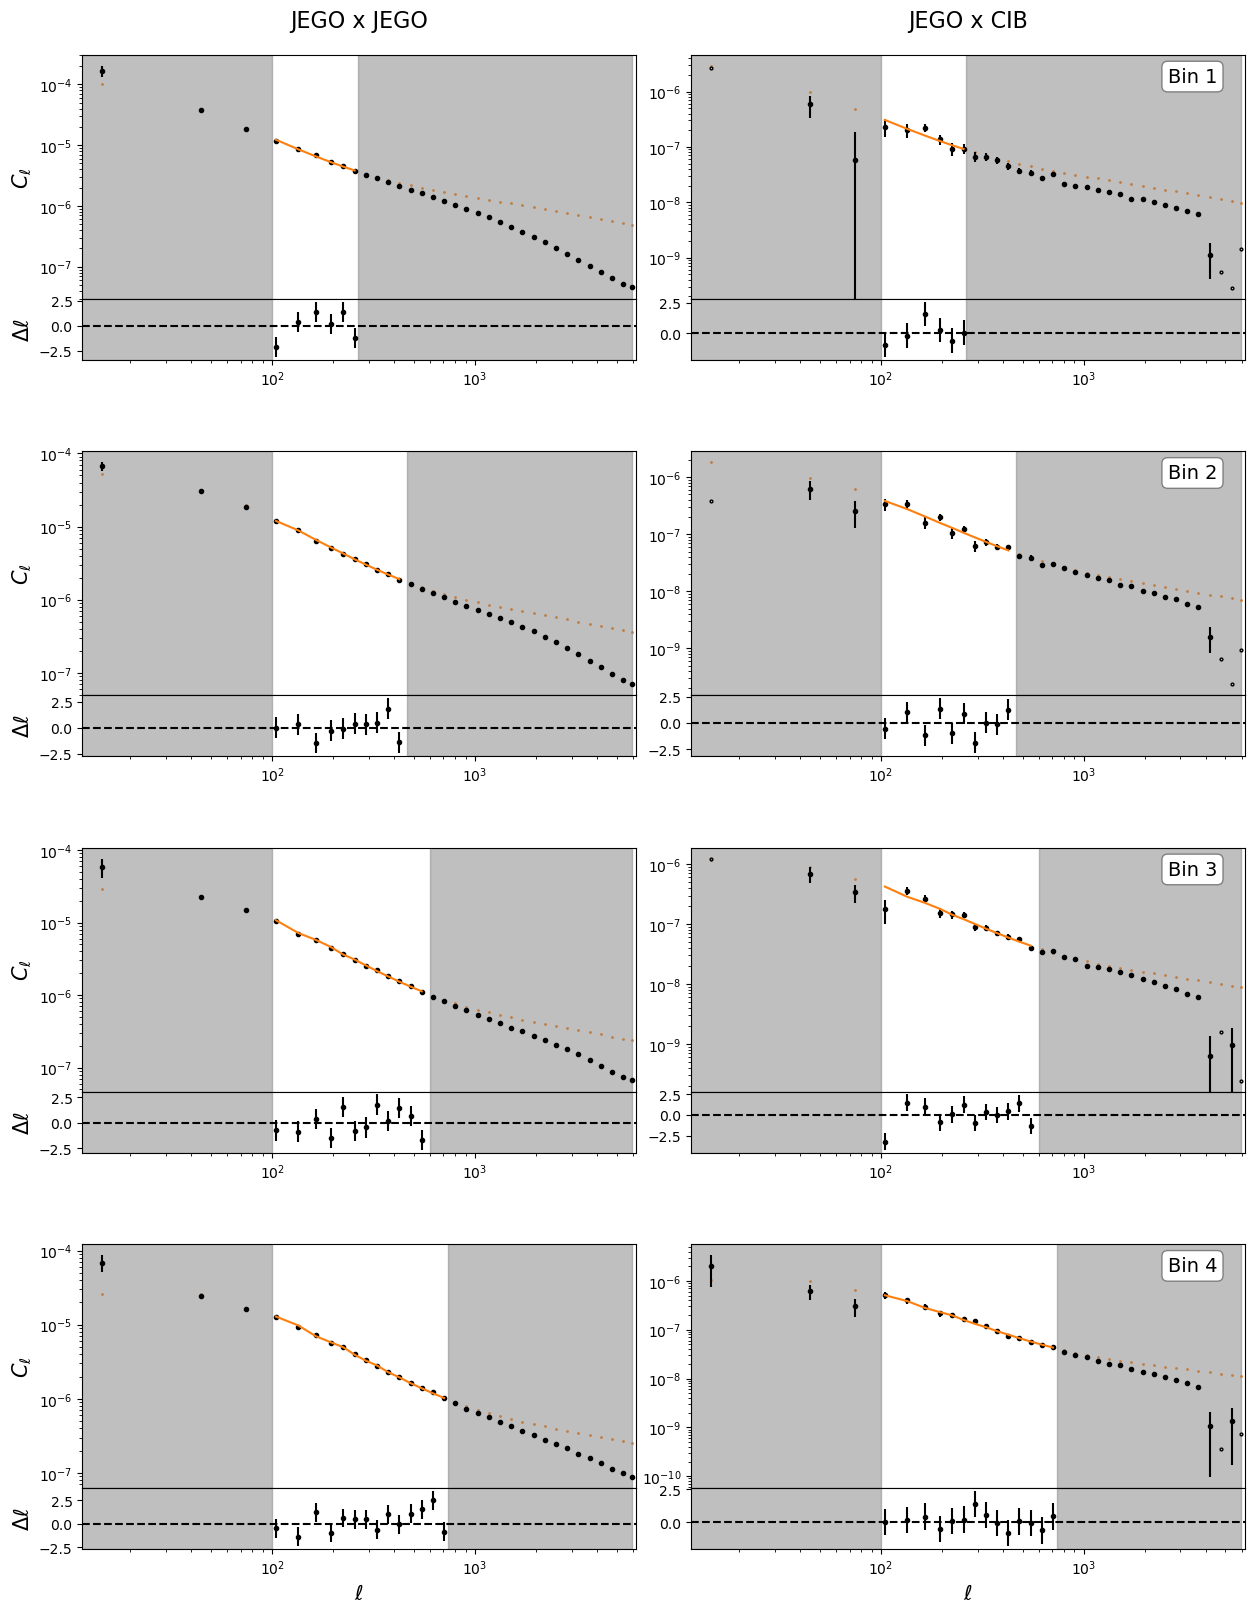

In [10]:
cut_pos = [mmodel.get_ell_max(tc) for tc in tracer_combos]
print(cut_pos)

modelled = mmodel.get_modelled_data(
    b_gs=np.array([1.157349, 1.356426, 1.304828, 1.727223]),
    N_ggs=np.array([-8.473147, -11.998453, -9.281538, -7.900928]),
    A_ggs=np.array([13.173976, 22.081414, 19.512082, 33.346164]),
    N_gnus=np.array([-8.979291, -9.101785, -14.458596, -15.0]),
    A_gnus=np.array([0.133122, 0.269631, 0.603964, 1.151559]),
    bpsfrs=np.array([0.018323, 0.030363, 0.043235, 0.052998]),
    full_ells=True,
)

measured_data = s.get_c_ells(tracer_combos)

errors = s.get_errors(tracer_combos)

print(measured_data[0][0])

plotter = ap.Plots(s)

plotter.create_grid_plot(
    subplot_titles=['JEGO x JEGO', 'JEGO x CIB'],
    subplot_tracer_combos=tracer_combos,
    measured_data=measured_data,
    measured_data_err=errors,
    modelled_data=modelled,
    cut_positions=[None, None],
    residuals=True,
    full_ells=True,
    variable_cuts=True,
    cut_pos = cut_pos
)